In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [12]:
train_dir = 'D:/machine learning/chest-xray-diagnosis/data/split/train'
val_dir = 'D:/machine learning/chest-xray-diagnosis/data/split/val'
test_dir = 'D:/machine learning/chest-xray-diagnosis/data/split/test'



In [13]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])  # for grayscale
])

In [14]:
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

In [15]:
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [17]:
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['normal', 'pneumonia', 'tb']


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
model = model.to(device)

d:\machine learning\chest-xray-diagnosis\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\machine learning\chest-xray-diagnosis\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\nayan/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:02<00:00, 12.8MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss:.4f}, Train Acc: {acc:.2f}%")


Epoch [1/10], Loss: 47.4378, Train Acc: 94.27%
Epoch [2/10], Loss: 24.1069, Train Acc: 96.88%
Epoch [3/10], Loss: 17.9598, Train Acc: 97.78%
Epoch [4/10], Loss: 13.2362, Train Acc: 98.45%
Epoch [5/10], Loss: 12.0162, Train Acc: 98.65%
Epoch [6/10], Loss: 5.8531, Train Acc: 99.41%
Epoch [7/10], Loss: 6.3755, Train Acc: 99.22%
Epoch [8/10], Loss: 5.6716, Train Acc: 99.39%
Epoch [9/10], Loss: 6.8789, Train Acc: 99.04%
Epoch [10/10], Loss: 4.9105, Train Acc: 99.43%


In [21]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

      normal       0.92      0.99      0.95       238
   pneumonia       1.00      0.97      0.98       641
          tb       1.00      1.00      1.00       105

    accuracy                           0.98       984
   macro avg       0.97      0.99      0.98       984
weighted avg       0.98      0.98      0.98       984



In [22]:
torch.save(model.state_dict(), 'D:/machine learning/chest-xray-diagnosis/models/chest_xray_densenet.pt')
print("Model saved!")


Model saved!


              precision    recall  f1-score   support

      normal       0.92      0.99      0.95       238
   pneumonia       1.00      0.97      0.98       641
          tb       1.00      1.00      1.00       105

    accuracy                           0.98       984
   macro avg       0.97      0.99      0.98       984
weighted avg       0.98      0.98      0.98       984



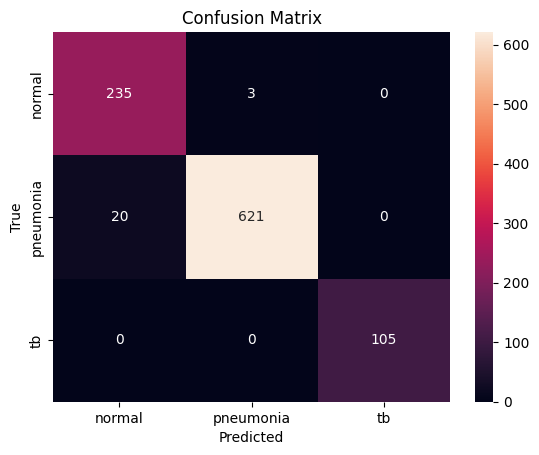

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print metrics
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
